# Drake practice - "Direct" Joint Angle Teleop
First, we provide a reference to the first example notebook of chapter 1. Then, in the bottom cell, you will find a similar function with slightly different functionality, and code missing that you are required to fill in. Take a look below for further instructions!

## Review: 2D End-effector Teleop (from Chapter 1)

In the chapter 1 [example](https://manipulation.csail.mit.edu/intro.html#teleop2d), we assembled a diagram with the manipulation station, a meshcat visualizer, some systems that provide a minimal teleop interface, along with some systems to convert the teleop output from end-effector commands into joint commands.

In this problem, your goal is to build an even simpler diagram, which instead directly controls the joint angles of the robot.


## Setup
Imports from drake and starting the Meshcat viewer.

In [8]:
import numpy as np
from pydrake.geometry import StartMeshcat
from pydrake.systems.analysis import Simulator
from pydrake.all import DiagramBuilder, MultibodyPlant

from manipulation import running_as_notebook
from manipulation.utils import RenderDiagram
from manipulation.exercises.grader import Grader
from manipulation.exercises.robot.test_direct_joint_control import (
    TestDirectJointControl,
)
from manipulation.station import MakeHardwareStation, load_scenario

In [2]:
# Start the visualizer.
meshcat = StartMeshcat()
meshcat.Set2dRenderMode(xmin=-0.25, xmax=1.5, ymin=-0.1, ymax=1.3)

INFO:drake:Meshcat listening for connections at http://localhost:7001


In [9]:
scenario_data = """
directives:
- add_model:
    name: iiwa
    file: package://manipulation/planar_iiwa14_no_collision.urdf
    default_joint_positions:
        iiwa_joint_2: [0.1]
        iiwa_joint_4: [-1.2]
        iiwa_joint_6: [1.6]
- add_weld:
    parent: world
    child: iiwa::iiwa_link_0
model_drivers:
    iiwa: !IiwaDriver {}
"""
scenario = load_scenario(data=scenario_data)

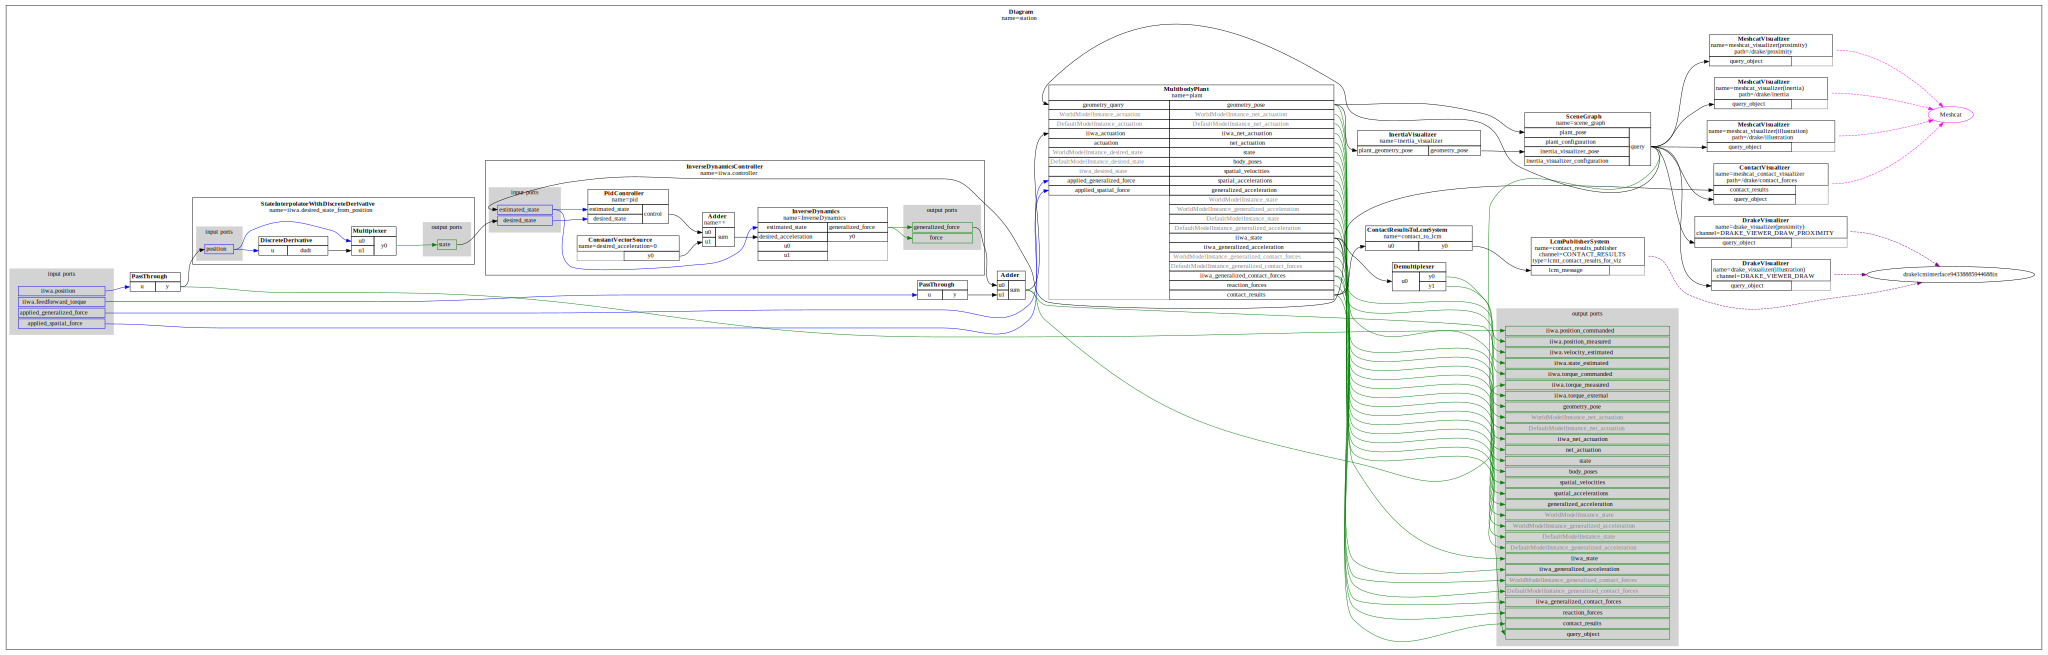

In [10]:
# view plot
station = MakeHardwareStation(scenario=scenario, meshcat=meshcat)
RenderDiagram(station)

## Directly control the robot joints
You'll now get a chance to replace the teleop functionality in the 2D example above with a direct "joint angle setter".

More specifically, we want you to complete the `teleop_2d_direct` function below, such that a user can directly pass in a desired angle of each joint and have the robot move to the commanded joint angles. You will have to make use of some drake functionality that's not used in the `teleop_2d` function (see [`FixValue`](https://drake.mit.edu/doxygen_cxx/classdrake_1_1systems_1_1_input_port.html#ab285168d3a19d8ed367e11053aec79c3) and [`CreateDefaultContext`](https://drake.mit.edu/doxygen_cxx/classdrake_1_1systems_1_1_system.html#ad047317ab91889c6743d5e47a64c7f08)) and you can leave out all the components that were used in `teleop_2d` which are no longer needed.

### The goals of this exercise are twofold:
- Understand the way core subsystems in Drake are wired together well enough to know which lines in the  `teleop_2d` function must be removed.
- Use the information in the examples from the textbook, other exercises, and Drake documentation, to correctly implement the same high-level joint-space control behavior, but using a different Drake function.


In [13]:
def teleop_2d_direct(interactive=False, q_cmd=np.zeros(3)):
    """
    Joint position control of the Kuka iiwa robot, without using teleop sliders or differential IK.

    Args:
        interactive (bool): If True, function will query the user to manually set the desired joint positions
            while running the simulator. Otherwise, function will use "q_cmd" as the target joint position.
        q_cmd (np.ndarray): Shape (3,). Desired positions of the three movable joints on the 2D robot.
            "q_cmd" cannot be None if "interactive" is set to False.
    """
    assert (
        not interactive and q_cmd is not None
    ) or interactive, 'Variable "q_cmd" must not be None if the function is run in non-interactive mode'

    station = MakeHardwareStation(scenario, meshcat=meshcat)

    #######################################################################
    # Your code here. Setup the simulation and context. Make sure that the
    # context variable is set to the context owned by the simulator.


    simulator = Simulator(station)
    context = simulator.get_mutable_context()

    #######################################################################

    if simulator is None:
        print("You must set the simulator variable above")
        return station, context

    simulator.set_target_realtime_rate(1.0 if interactive else 0)
    meshcat.AddButton("Stop Simulation")
    while meshcat.GetButtonClicks("Stop Simulation") < 1:
        simulator.AdvanceTo(simulator.get_context().get_time() + 2.0)

        #######################################################################
        # Your code here
        # (read the current measured joint angles into the variable `q_current`)
        # (hint: what output ports does the `station` instance have available?)

        
        q_current = np.array(station.GetOutputPort("iiwa.position_measured").Eval(context))
        print(f"Current joint angles: {q_current}")

        #######################################################################

        if interactive and running_as_notebook:
            q_cmd = q_current.copy()
            q_cmd[0] = float(
                input(
                    f"Please enter value for first movable joint (current value: {q_current[0]:.3f})"
                )
            )
            q_cmd[1] = float(
                input(
                    f"Please enter value for second movable joint (current value: {q_current[1]:.3f})"
                )
            )
            q_cmd[2] = input(
                f"Please enter value for third movable joint (current value: {q_current[2]:.3f})"
            )

        #######################################################################
        # Your code here
        # (command the desired joint positions, and read the joint angle command into variable `q_current_cmd`)

        q_current_cmd = station.GetInputPort("iiwa.position").FixValue(
            context,
            q_cmd
        )
        print(f"Current commanded joint angles: {q_current_cmd}\n")

        #######################################################################

        if not interactive or not running_as_notebook:
            break

    meshcat.DeleteButton("Stop Simulation")

    return station, context

Run the cell below to use the function you wrote in an interactive mode, but note that the autograder will test the functionality of your code in non-interactive mode.

In [14]:
teleop_2d_direct(interactive=True)

Current joint angles: [-0.0001471   0.00229092 -0.00309481]
Current commanded joint angles: <pydrake.systems.framework.FixedInputPortValue object at 0x7f33961cccb0>

Current joint angles: [2.09439516 2.09439519 2.0943953 ]
Current commanded joint angles: <pydrake.systems.framework.FixedInputPortValue object at 0x7f339624a7b0>

Current joint angles: [2.09439532 2.09439517 2.09439516]


ValueError: could not convert string to float: ''

## How will this notebook be Graded?

If you are enrolled in the class, this notebook will be graded using [Gradescope](www.gradescope.com). You should have gotten the enrollement code on our announcement in Piazza.

For submission of this assignment, you must do as follows:.
- Download and submit the notebook `direct_joint_control.ipynb` to Gradescope's notebook submission section, along with your notebook for the other problems.

We will evaluate the local functions in the notebook to see if the function behaves as we have expected. For this exercise, the rubric is as follows:
- [5pts] `teleop_2d_direct` must be implemented correctly (i.e., we will check if you are properly sending position commands to the robot)

Below is our autograder where you can check your score!

In [15]:
Grader.grade_output([TestDirectJointControl], [locals()], "results.json")
Grader.print_test_results("results.json")

Total score is 5/5.

Score for Test iiwa_position_measured is 5/5.
- Current joint angles: [-0.0001471   0.00229092 -0.00309481]
Current commanded joint angles: <pydrake.systems.framework.FixedInputPortValue object at 0x7f3396266f30>




<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8f86172b-b597-4ceb-9bad-92d11ac7a6cc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>